## Sync Pulse Alignment Results

Notebook that compiles results of my investigation into the purported system 1 sync pulse alignment error.  Final code for this work can be found on [GitHub](https://github.com/hherrema/CML_programming_data/tree/main/sync_pulse_alignment).

In [1]:
# imports
import pandas as pd
import cmlreaders as cml
from find_bad_sync_pulse_alignment import AlignmentCheck
import seaborn as sns
import matplotlib.pyplot as plt
from sync_pulse_cml import sync_pulse_aligner_cml
from sync_pulse_align import sync_pulse_aligner
from tqdm.notebook import tqdm
import numpy as np
import warnings; warnings.filterwarnings("ignore")

### 1. Statement of the problem

For alignment with sync pulses, the principle is that sync pulse events should have a random (jittered) offset sequence, matching in the event log and in the recorded syncs measured in the eeg file.  Therefore, when aligning, you just need to find the position where the behavioral and eeg sync pulses lock into place.

The purported error holds that a version of the syncbox driver erroneously assigned an extra jitter, which in turn leads our `eegoffset` markings for behavioral events to not actually represent the correct corresponding samples in the EEG.  Real pulses recorded in the EEG file are randomly delayed about 0-1 seconds from when they were supposed to happen according to the behavioral log.  Therefore, the "aligned" EEG data has an average offset of approximately 0.5s from the events.

The measurement to check if a given session has this erroneous additional sync jitter is via the distribution of residuals of the alignment of recorded sync pulse events and EEG sync pulses.

#### Methods

For each session, a linear regression will be run on the inter-pulse times, sent (behavioral) and received (EEG), once the sessions has been aligned.  From the regression, the distribution of residuals can be calculated, where the stastic of interest is the standard deviation.  *A low standard deviation in the residual distribution would suggest the session does not contain the erroneous jitter, while a large standard deviation would flag a session as problematic*.

#### System 1 sessions

The sync pulse alignment issue is contained to sessions that used sync pulses (the syncbox) to align behavioral events and EEG data.  In other words, system 1 sessions.  On the cmlreaders data index, there are 1344 intracranial sessions with NaN system version, 186 sessions labeled system 1, and 378 pyFR sessions that are known to be system 1.  I wrote `system_version_finder.py` to determine the system version for the NaN sessions, finding 857 system 1 sessions.  In all, this means there are **1421 system 1 sessions on the cmlreaders data index**.

In [2]:
df_sys1 = pd.read_csv('df_sys1.csv')
df_sys1

,subject,subject_alias,experiment,original_experiment,session,original_session,system_version
0,FR240,NaN,pyFR,NaN,0,NaN,1.0
1,FR240,NaN,pyFR,NaN,2,NaN,1.0
2,CP001,NaN,pyFR,NaN,1,NaN,1.0
3,CP001,NaN,pyFR,NaN,2,NaN,1.0
4,CP001,NaN,pyFR,NaN,3,NaN,1.0
...,...,...,...,...,...,...,...
1416,R1582E,R1582E,RepFR1,NaN,2,NaN,1.0
1417,R1585E,R1585E,DBOY1,NaN,0,NaN,1.0
1418,R1593D,R1593D,RepFR1,NaN,0,NaN,1.0
1419,R1593D,R1593D,RepFR1,NaN,1,NaN,1.0


#### Finding sync.txt files

For each system 1 session, there is a `sync.txt` file that contains the array of EEG sync pulses.  Unfortunately, there is not a standard nomenclature, only patterns.  Along with subject aliases for re-implants, differences in "session" and "original session" and "experiment" and "original experiment," this makes locating the file that corresponds with each sessions rather difficult.  I wrote functions in `sync_txt_finder.py` to attempt to locate the sync files for the system 1 sessions on cmlreaders.  In the end, I was able to correctly locate `sync.txt` files for 1013 of the 1421 system 1 sessions on rhino.  Notably, 368 of the 408 outstanding sessions are pyFR, for which the sync files often do not include the session number in the filename.  A resolution for this would require matching date-time-stamps for the sessions.

In [3]:
valid_sync_files = pd.read_csv('sync_pulse_CML/valid_sync_files.csv')
valid_sync_files

,subject,subject_alias,experiment,original_experiment,session,original_session,sync_txt
0,TJ055,NaN,pyFR,NaN,1,NaN,/data/eeg/TJ055/eeg.noreref/TJ055_10Feb13_1125...
1,TJ082,NaN,pyFR,NaN,0,NaN,/data/eeg/TJ082/eeg.noreref/TJ082_31Aug14_1336...
2,TJ083,NaN,pyFR,NaN,0,NaN,/data/eeg/TJ083/eeg.noreref/TJ083_23Aug14_1214...
3,UP045,NaN,pyFR,NaN,0,NaN,/data/eeg/UP045/eeg.noreref/UP045_14Jul14_1148...
4,UP045,NaN,pyFR,NaN,1,NaN,/data/eeg/UP045/eeg.noreref/UP045_15Jul14_1337...
...,...,...,...,...,...,...,...
1008,R1582E,R1582E,RepFR1,NaN,2,NaN,/data/eeg/R1582E/eeg.noreref/RepFR1_2.sync.txt
1009,R1585E,R1585E,DBOY1,NaN,0,NaN,/data/eeg/R1585E/eeg.noreref/DBOY1_0.sync.txt
1010,R1593D,R1593D,RepFR1,NaN,0,NaN,/data/eeg/R1593D/eeg.noreref/RepFR1_0.sync.txt
1011,R1593D,R1593D,RepFR1,NaN,1,NaN,/data/eeg/R1593D/eeg.noreref/RepFR1_1.sync.txt


In [4]:
no_sync_txt = pd.read_csv('sync_pulse_CML/no_sync_txt.csv')
no_sync_txt

,subject,subject_alias,experiment,original_experiment,session,original_session
0,FR240,NaN,pyFR,NaN,0,NaN
1,FR240,NaN,pyFR,NaN,2,NaN
2,CP001,NaN,pyFR,NaN,1,NaN
3,CP001,NaN,pyFR,NaN,2,NaN
4,CP001,NaN,pyFR,NaN,3,NaN
...,...,...,...,...,...,...
403,R1284N,R1284N,PAL3,NaN,2,NaN
404,R1284N,R1284N,PS2.1,PS21,0,NaN
405,R1289C,R1289C,TH1,NaN,3,NaN
406,R1289C,R1289C,TH1,NaN,5,NaN


### 2. Results from Joey's Code

Joey took a cursory look at this issue, and wrote the class `AlignmentCheck`, found in `find_bad_sync_pulse_alignment.py`, to analyze sync pulse alignments.  He took a correlational approach to finding the alignment, essentially sliding the array of behavioral sync pulses over the array of EEG sync pulses, calculating a correlation at each index, and then taking the greatest correlation as the found alignment.

I ran his code, out of the box, over a number of sync pulse sessions.  His code ran successfully on only 415 sessions, some of which I think aren't even locating the correct sync files.  Regardless, this is a large enough set to show what I believe are some issues with his method.

In [5]:
# inspect individual sessions
def run_JR_sess(sub, exp, sess):
    ac = AlignmentCheck(sub, exp, sess)
    ac.check(plot=True)

In [6]:
results_jr = pd.read_csv('sync_pulse_JR/sync_pulse_checks_JR_results.csv')
results_jr

,subject,experiment,session,slope,intercept,rmse,mu,sig,se,n_syncs,corr1,corr2
0,R1001P,FR1,0,0.994577,6.265024,9.886851,2.273737e-14,9.886851,0.988685,100,0.997433,0.307165
1,R1001P,FR2,0,0.996519,4.390141,10.377176,5.275069e-13,10.377176,1.037718,100,0.997789,0.304329
2,R1001P,PAL1,0,0.993616,7.375200,9.720489,1.932676e-14,9.720489,0.972049,100,0.997734,0.348819
3,R1001P,FR1,1,0.998436,-3.881137,1.707378,-2.626166e-13,1.707378,0.170738,100,0.999934,0.349083
4,R1001P,PAL1,1,0.996626,4.147123,8.459647,3.763034e-13,8.459647,0.845965,100,0.998297,0.361811
...,...,...,...,...,...,...,...,...,...,...,...,...
410,R1572T,FR1,0,0.999896,0.095079,0.457905,-3.092282e-13,0.457905,0.045791,100,0.999995,0.329274
411,R1573T,DBOY1,0,0.361150,640.038046,136.778121,3.717560e-13,136.778121,13.677812,100,0.287059,0.269639
412,R1573T,FR1,0,0.998975,0.991827,0.712494,2.410161e-13,0.712494,0.071249,100,0.999988,0.327682
413,R1582E,RepFR1,0,4.157082,-2831.202391,802.491709,5.078012e-13,802.491709,103.601234,60,0.466572,0.409839


#### Example of a flagged session from Joey's code

Below is an example of a session that Joey's code flags as having the erroneous jitter error.  The slope of the regression is not close to 1, and the residuals are evidentely considerable.

/data/eeg/R1001P/eeg.noreref/*FR2_1*.sync.txt


  0%|          | 0/2840 [00:00<?, ?it/s]

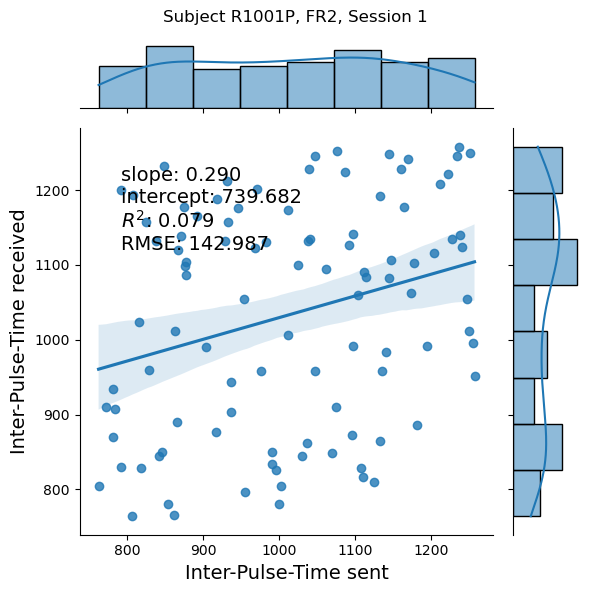

In [7]:
sub = 'R1001P'
exp = 'FR2'
sess = 1
run_JR_sess(sub, exp, sess)

#### Faults in the correlational approach

It appears that the poor fits in Joey's results are all for sessions where the maximum correlation is low.  Recall that Joey's code takes the maximum correlation and calls that the alignment.  Also to note, in instances where there is a large gap in pulse times (i.e., a large inter-pulse time, which happens quite frequently), Joey's code simply remove array values until there is no gap, which leads to finding alignments based on an even smaller subset of syncs.

Plotting the standard deviation of the residual distribution as a function of the maximum (aligned) correlation shows that the sessions with large residual standard deviations had low maximum correlations.  Moreover, all the sessions with a maximum correlation close to 1 had very low (near zero) residual standard deviation.

Plotting the maximum (aligned) correlation with the 2nd highest correlation for each session show that, for sessions without a high maximum correlation, the second greatest correlation is almost equivalent.

Together, these findings suggest that the sessions Joey's code flagged may actually simply be because his code did not find the correct alignment.  When it did (i.e., correlation close to 1), we don't see the worrying distributions of residuals.

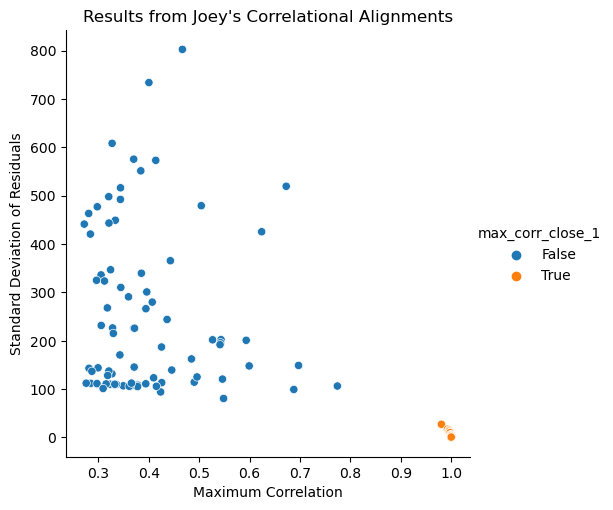

In [8]:
results_jr['max_corr_close_1'] = results_jr['corr1'] > 0.9
# plot standard deviation of residuals as a function of aligned correlation for Joey's results
ax = sns.relplot(results_jr, x='corr1', y='sig', hue='max_corr_close_1')
ax.set(xlabel='Maximum Correlation', ylabel='Standard Deviation of Residuals', title="Results from Joey's Correlational Alignments")
plt.show()

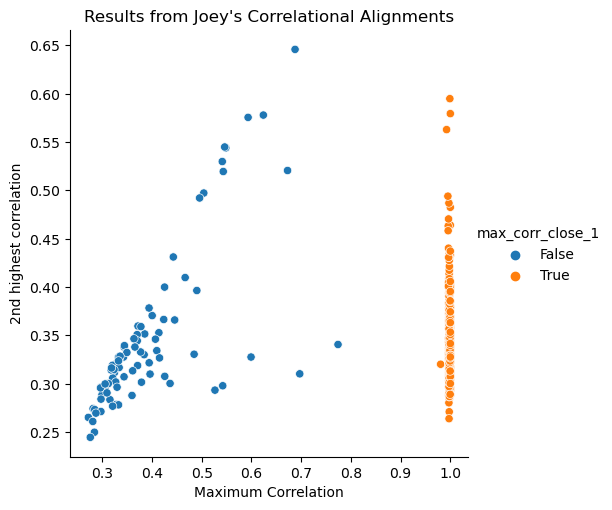

In [9]:
# plot maximum correlation and second highest correlation for Joey's results
ax = sns.relplot(results_jr, x='corr1', y='corr2', hue='max_corr_close_1')
ax.set(xlabel='Maximum Correlation', ylabel='2nd highest correlation', title="Results from Joey's Correlational Alignments")
plt.show()

### 3. Results from Haydn's Code

I wrote two classes, `sync_pulse_aligner` found in `sync_pulse_cml.py` and `sync_pulse_aligner_cml` found in `sync_pulse_cml.py` to analyze sync pulse alignments.  Both classes utilize the alignment machinery present in event creation for system 1, which essentially searches for the lock between the signatures of behavioral and EEG sync pulses.  I started by searching rhino for every `sync.txt` I could find, and then tried to determine which of those were from experimental sessions, and attemtped to align those.  This is what I built `sync_pulse_aligner` for, but I realized the more important question to answer was: for the sessions on the cmlreaders data index, are we confident they have an error-free alignment.  Therefore, starting from the 1421 system 1 sessions on the cmlreaders data index, I tried to find the corresponding `sync.txt` and then ran the alignment checks in `sync_pulse_aligner_cml`.  As mentioned above, the checks ran on the 1013 sessions with a found `sync.txt`.

Another important distinction between my code and Joey's is that I handled large gaps in the pulse times (i.e., abnormally large > 5000 ms/samples inter-pulse times) by piecing together the gap, as oppsoed to discarding data from after the gap.  Specifically, for all times after the gap, I subtracted the first time after the gap, added the final time before the gap, and added the mean difference times before the gap.  That way, instead of an incredibly large inter-pulse time showing up in the arrays, that value is replaced with a value similar to others.  For my linear regression, I actually just remove any abnormally large inter-pulse times, but preserve values from before and after any gaps.

The following results are from running alignment checks over the sessions on the cmlreaders data index.

In [10]:
# inspect individual sessions
def run_CML_sess(sub, exp, sess, vsf):
    # find sync pulse text file
    row = vsf[(vsf.subject==sub) & (vsf.experiment==exp) & (vsf.session==sess)].iloc[0]
    spa = sync_pulse_aligner_cml(row.subject, row.subject_alias, row.experiment, row.original_experiment, row.session, row.original_session, row.sync_txt)
    spa.run_align()
    spa.run_QC()
    spa.plot_results()

In [11]:
results_cml = pd.read_csv('sync_pulse_CML/sync_pulse_checks_CML_results.csv')
err_df = pd.read_csv('sync_pulse_CML/err_df.csv')
results_cml

,subject,subject_alias,experiment,original_experiment,session,original_session,slope,intercept,rmse,mu,sig,se,n_syncs
0,TJ082,NaN,pyFR,NaN,0,NaN,1.000095,-0.111760,0.670120,1.194286e-13,0.670120,0.047623,200
1,UP045,NaN,pyFR,NaN,0,NaN,0.999791,0.686661,1.838429,6.545606e-14,1.838429,0.130651,200
2,UP045,NaN,pyFR,NaN,1,NaN,1.000151,0.311750,1.581415,3.100550e-14,1.581415,0.112386,200
3,UP045,NaN,pyFR,NaN,2,NaN,0.999562,0.433769,1.901875,6.488188e-14,1.901875,0.135160,200
4,UP045,NaN,pyFR,NaN,3,NaN,0.999436,0.586058,2.009739,2.411539e-14,2.009739,0.142826,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,R1582E,R1582E,RepFR1,NaN,2,NaN,1.004431,-4.857705,4.549622,-3.157968e-14,4.549622,1.072356,20
985,R1585E,R1585E,DBOY1,NaN,0,NaN,1.001429,-1.335059,3.941849,-4.909204e-14,3.941849,0.420203,90
986,R1593D,R1593D,RepFR1,NaN,0,NaN,1.002631,-2.586050,1.039251,8.842310e-14,1.039251,0.244954,19
987,R1593D,R1593D,RepFR1,NaN,1,NaN,-1.008443,2098.615032,95.632079,2.219885e-11,95.632079,21.939504,20


#### Example of flagged session now appearing correct

Below I plot the results of my alignment code for a session that Joey's code flagged as having the erroneous extra jitter.  Here, we see a good alignment with a very small standard deviation of the residuals.  This suggests that Joey's code simply did not find the correct alignment for this session.

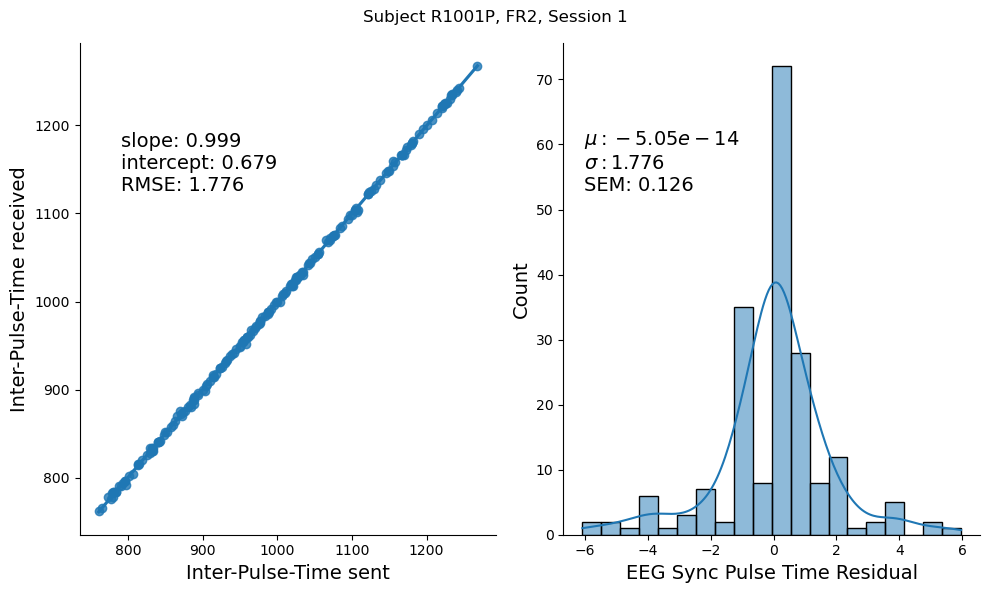

In [12]:
sub = 'R1001P'
exp = 'FR2'
sess = 1
run_CML_sess(sub, exp, sess, valid_sync_files)

#### Summary of results

1421 system 1 sessions on cmlreaders data index.
- 1013 sessions with found sync.txt, run through alignment checks.
    - **989 sessions successfully aligned (i.e., no errors in script).**
        - 2 sessions questionable (high sigma on residual distribution).
    - 24 sessions not successfully aligned.
        - 2 sessions unable to locate behavioral sync log.
        - 22 sessions fail alignment because alignment window (i.e., number of matching inter-pulse times) becomes too small.

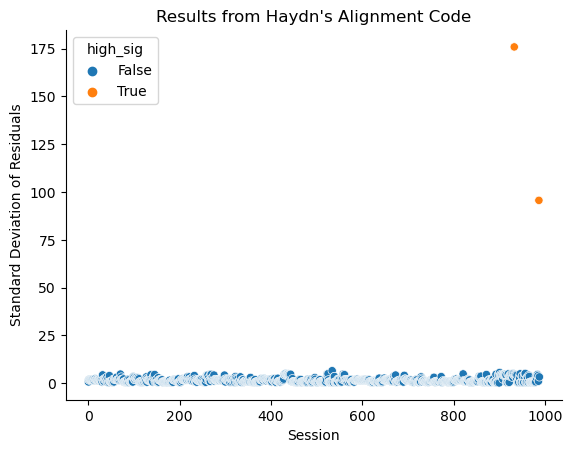

In [13]:
# plot standard deviation of residual distribution for aligned sessions
results_cml['high_sig'] = results_cml.sig > 10
ax = sns.scatterplot(results_cml, x=results_cml.index, y='sig', hue='high_sig')
ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel='Session', ylabel='Standard Deviation of Residuals', title="Results from Haydn's Alignment Code")
plt.show()

#### Successful alignment, large residual standard deviation

These sessions have a negative slope from the regression, suggesting there is something awry, which my just be negative values for some inter-pulse times.

In [14]:
# two successfully aligned sessions with large residual standard deviation
results_cml[results_cml['high_sig']]

,subject,subject_alias,experiment,original_experiment,session,original_session,slope,intercept,rmse,mu,sig,se,n_syncs,high_sig
933,R1544E,R1544E,DBOY1,NaN,0,NaN,-1.261293,2253.776929,175.890403,8.455101e-13,175.890403,12.468540,200,True
987,R1593D,R1593D,RepFR1,NaN,1,NaN,-1.008443,2098.615032,95.632079,2.219885e-11,95.632079,21.939504,20,True


#### Successful alignment --> trustworthy sessions

987 sessions on cmlreaders that I am confident we can trust the alignment for.

In [15]:
# sessions successfully aligned with good looking residual distribution
good_align = results_cml[results_cml['high_sig'] == False]
good_align.to_csv('sync_pulse_CML/good_align.csv', index=False)
good_align

,subject,subject_alias,experiment,original_experiment,session,original_session,slope,intercept,rmse,mu,sig,se,n_syncs,high_sig
0,TJ082,NaN,pyFR,NaN,0,NaN,1.000095,-0.111760,0.670120,1.194286e-13,0.670120,0.047623,200,False
1,UP045,NaN,pyFR,NaN,0,NaN,0.999791,0.686661,1.838429,6.545606e-14,1.838429,0.130651,200,False
2,UP045,NaN,pyFR,NaN,1,NaN,1.000151,0.311750,1.581415,3.100550e-14,1.581415,0.112386,200,False
3,UP045,NaN,pyFR,NaN,2,NaN,0.999562,0.433769,1.901875,6.488188e-14,1.901875,0.135160,200,False
4,UP045,NaN,pyFR,NaN,3,NaN,0.999436,0.586058,2.009739,2.411539e-14,2.009739,0.142826,200,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,R1582E,R1582E,RepFR1,NaN,1,NaN,0.995503,4.554501,4.043708,6.545606e-14,4.043708,0.703919,34,False
984,R1582E,R1582E,RepFR1,NaN,2,NaN,1.004431,-4.857705,4.549622,-3.157968e-14,4.549622,1.072356,20,False
985,R1585E,R1585E,DBOY1,NaN,0,NaN,1.001429,-1.335059,3.941849,-4.909204e-14,3.941849,0.420203,90,False
986,R1593D,R1593D,RepFR1,NaN,0,NaN,1.002631,-2.586050,1.039251,8.842310e-14,1.039251,0.244954,19,False


#### Unable to locate behavioral sync log

These sessions have duplicate folders on rhino and confusing naming.

In [16]:
# sessions unable to locate behavioral sync log
err_df[err_df['error'] == 'Unable to locate behavioral sync pulse log']

,subject,subject_alias,experiment,original_experiment,session,original_session,error
0,TJ055,NaN,pyFR,NaN,1,NaN,Unable to locate behavioral sync pulse log
1,TJ083,NaN,pyFR,NaN,0,NaN,Unable to locate behavioral sync pulse log


#### Failed alignment

"Alignment window too small" means no alignment was found even when decreasing the number of matching inter-pulse times.  These sessions are dubious. Notably, most are PS sessions, which have confusing session numbering and directory naming on rhino, so there is a chance some of these sessions attempted alignment with non-matching behavioral and EEG sync logs (i.e., from different sessions/experiments).

In [17]:
# sessions with failed alignment
err_df[err_df['error'] == 'Alignment window too small']

,subject,subject_alias,experiment,original_experiment,session,original_session,error
2,R1047D,R1047D,YC1,NaN,0,0.0,Alignment window too small
3,R1060M,R1060M,PS2,PS,0,5.0,Alignment window too small
4,R1069M,R1069M,FR2,NaN,0,0.0,Alignment window too small
5,R1106M,R1106M,YC1,NaN,0,1.0,Alignment window too small
6,R1112M,R1112M,PS2,PS,0,1.0,Alignment window too small
7,R1112M,R1112M,PS2,PS,1,6.0,Alignment window too small
8,R1112M,R1112M,PS2,PS,2,7.0,Alignment window too small
9,R1112M,R1112M,PS2,PS,5,17.0,Alignment window too small
10,R1112M,R1112M,PS3,PS,0,10.0,Alignment window too small
11,R1112M,R1112M,PS3,PS,1,11.0,Alignment window too small


#### Experiment breakdown

One hypothesis was that the issue resulted from a bug in the code for a particular experiment.  This, however, does not appear to be the case, as all experiments have a majority of successful alignments.

In [18]:
all_exps = set(results_cml.experiment).union(set(err_df.experiment))
exp_df = pd.DataFrame(columns = ['experiment', 'success', 'no_beh_sync_log', 'window_too_small'])
for exp in all_exps:
    success = len(results_cml[results_cml.experiment == exp])
    error1 = len(err_df[(err_df.experiment == exp) & (err_df.error == 'Unable to locate behavioral sync pulse log')])
    error2 = len(err_df[(err_df.experiment == exp) & (err_df.error == 'Alignment window too small')])
    exp_df = pd.concat([exp_df, pd.DataFrame({'experiment': exp, 'success': success, 'no_beh_sync_log': error1, 'window_too_small': error2}, index=[len(exp_df)])])
    
exp_df

,experiment,success,no_beh_sync_log,window_too_small
0,PAL1,82,0,1
1,catFR1,86,0,0
2,PS3,38,0,6
3,PS2,138,0,10
4,pyFR,8,2,0
5,FR2,74,0,1
6,YC1,89,0,2
7,PAL2,26,0,0
8,TH1,38,0,0
9,DBOY1,66,0,0


#### On YellowCab (YC1, YC2)

A majority of the YC1 and YC2 sessions contained multiple (2) gaps in the sync pulse times (i.e., abnormally large inter-pulse times).  On investigation, the second gap consistently occured at index 99 of the sync pulses time arrays, but I've not been able to get to the bottom of why.  

Regardless, the alignment is successful even with the gaps, and when running the regression on the inter-pulse time arrays with the gaps masked out, the alignment looks good with low residual standard deviation.

Below, I plot the inter-sync pulse time at index 99 for the YC1 and YC2 sessions, and it is evident that there is often a large gap here.

0it [00:00, ?it/s]

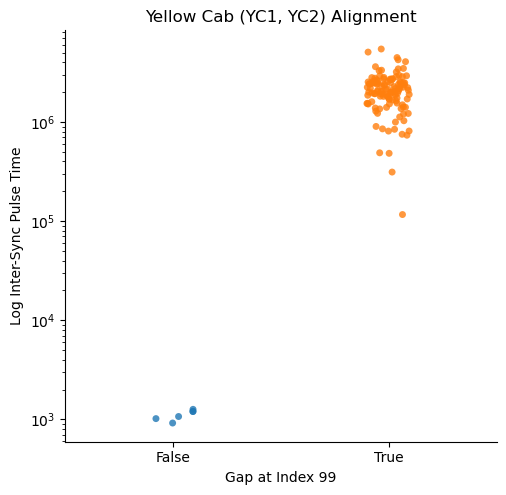

In [19]:
def yellow_cab_gaps(valid_sync_files):
    gap_diffs = []

    for _, row in tqdm(valid_sync_files.query("experiment in ['YC1', 'YC2']").iterrows()):
        try:
            vsf = valid_sync_files[(valid_sync_files.subject==row.subject) &
                                        (valid_sync_files.experiment==row.experiment) &
                                        (valid_sync_files.session==int(row.session))].iloc[0]
            spa = sync_pulse_aligner_cml(vsf.subject, vsf.subject_alias, vsf.experiment, vsf.original_experiment, 
                                         vsf.session, vsf.original_session, vsf.sync_txt)
            spa.run_align()
            bsd = np.diff(spa.matching_beh_syncs)
            esd = np.diff(spa.matching_eeg_syncs)
            no_gap_idx = np.intersect1d(np.where(bsd < 5E3), np.where(esd < 5E3))
            gap_idx = np.intersect1d(np.where(bsd >= 5E3), np.where(esd >= 5E3))

            if 99 in gap_idx:
                gap_diffs.append((True, esd[99]))
            else:
                gap_diffs.append((False, esd[99]))
        except BaseException as e:
            continue

    return pd.DataFrame(gap_diffs, columns=['idx_99', 'ispt'])

yc_gaps = yellow_cab_gaps(valid_sync_files)
ax = sns.catplot(yc_gaps, x='idx_99', y='ispt', hue='idx_99', alpha=0.8)
ax.set(yscale='log', xlabel='Gap at Index 99', ylabel='Log Inter-Sync Pulse Time', title='Yellow Cab (YC1, YC2) Alignment')
plt.show()

### Dubious alignment sessions

System 1 sessions on the cmlreaders data index that are not confirmed to have trustworthy alignments.

- Successfully aligned but with large standard deviation of residuals.
- Errors on alignment checks.
    - Missing behavioral sync pulse logs.
    - Alignment window becomes to small before alignment found.
- No found EEG sync logs.

In [20]:
cols = ['subject', 'subject_alias', 'experiment', 'original_experiment', 'session', 'original_session']

# successfully aligned, large standard deviation of residuals
high_sig = results_cml[results_cml['high_sig']][cols]
high_sig['error'] = 'High residual standard deviation'

# errors on alignment checks alreadey have 'error' column

# no found sync.txt
no_sync_txt['error'] = 'No found EEG sync log'

# concatenate and write out all dubious alignment sessions
question_align = pd.concat([high_sig, err_df, no_sync_txt])
question_align.to_csv('sync_pulse_CML/question_align.csv', index=False)
question_align

,subject,subject_alias,experiment,original_experiment,session,original_session,error
933,R1544E,R1544E,DBOY1,NaN,0,NaN,High residual standard deviation
987,R1593D,R1593D,RepFR1,NaN,1,NaN,High residual standard deviation
0,TJ055,NaN,pyFR,NaN,1,NaN,Unable to locate behavioral sync pulse log
1,TJ083,NaN,pyFR,NaN,0,NaN,Unable to locate behavioral sync pulse log
2,R1047D,R1047D,YC1,NaN,0,0.0,Alignment window too small
...,...,...,...,...,...,...,...
403,R1284N,R1284N,PAL3,NaN,2,NaN,No found EEG sync log
404,R1284N,R1284N,PS2.1,PS21,0,NaN,No found EEG sync log
405,R1289C,R1289C,TH1,NaN,3,NaN,No found EEG sync log
406,R1289C,R1289C,TH1,NaN,5,NaN,No found EEG sync log


### 4. Discussion

In conclusion, we have a sizeable subset of system 1 sessions on the cmlreaders data index that are confirmed to have trustworthy alignments.  There are a handful (22 + 2 + 2 = 26) that are questionable.  I would like to look more into these, which would require developing an alternative method to finding an alignment, and from there checking the distribution of residuals.  Also, more work can be done to try to find the `sync.txt` files for the remaining 408 system 1 sessions on the cmlreaders data index.  However, since 368 of these are pyFR, which showed successful alignment for all attempted alignments, we can hedge our bets that for the most part, the pyFR sessions are good.  This leaves another 40 sessions for which there were no alignment checks.

It is worth mentioning that in my original attempts, where I parsed all of rhino for any `sync.txt` files, I found many files that are not connected to a session on the data index.  A large number of these are from paradigms that aren't in cmlreaders at all, but according to my initial analyses, I found 275 sessions that fail my (original) alignment checks that are not on cmlreaders.  I also believe there are sessions that passed my alignment checks but are not on cmlreaders.  This is all to say that: one, there is likely a considerable amount of data on rhino that is not available on cmlreaders, which is potentially recoverable, and two, *it is possible that many (or all) of the erroneous jitter sessions were never successfully processed (if the jitter made alignment intractable), and therefore aren't on cmlreaders*.

**Alas, for the 1421 system 1 sessions on the cmlreaders data index, I am confident we can trust 987 sessions (`good_align.csv`) and there are 434 sessions with questionable alignments (`question_align.csv`), although the only I think analysts ought to be really wary of are those that failed alignment due to the "Alignment window becoming too small" error (22 sessions).**